In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import torch
import time
import random
import shutil
import cv2
import copy
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/week2/project/pytorch-template/alexnet/data/cervical/labeled_1-1000
!ls

In [50]:
class CervicalDataset(Dataset):
    '''
    dataloader에서 쓰일 custom dataset
    '''
    def __init__(self, data_dir, label_dir,  transform=None ):
        self.label_dir = pd.read_csv(label_dir)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.data_dir))

    def __getitem__(self, idx):
        img_path = self.data_dir + "{}_01.jpg".format(self.label_dir.iloc[idx, 1])
        image = Image.open(img_path)
        # image = np.array(image)
        
        if self.transform:
            image = self.transform(image)
            
        image = torch.FloatTensor(image)
        label = self.label_dir.iloc[idx, -1]

        return image, label

In [51]:
label_dir = '/content/drive/MyDrive/ColabNotebooks/week2/project/pytorch-template/alexnet/data/cervical/data_20220929.csv'
img_dir = '/content/drive/MyDrive/ColabNotebooks/week2/project/pytorch-template/alexnet/data/cervical/labeled_1-1000/'

In [52]:
dataset = CervicalDataset(img_dir, label_dir,
                           transform = transforms.Compose([
                              transforms.Resize((224, 224)),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ])
                           )

In [53]:
image, label = next(iter(dataset))
image, label

(tensor([[[ 2.0434,  2.1119,  2.0092,  ..., -1.3473, -1.5014, -1.5870],
          [ 1.9407,  1.9920,  1.9920,  ..., -1.5185, -1.5870, -1.5528],
          [ 1.8893,  1.9749,  1.9920,  ..., -1.5699, -1.5014, -1.4329],
          ...,
          [-0.2856, -0.2342,  0.0912,  ...,  0.1768, -0.0629, -0.3712],
          [-0.0801, -0.0116,  0.1083,  ..., -0.0116, -0.1657, -0.0972],
          [-0.1314, -0.0801,  0.0912,  ..., -0.1314, -0.1828, -0.0116]],
 
         [[ 2.2185,  2.2885,  2.1835,  ..., -1.2479, -1.4055, -1.4930],
          [ 2.1134,  2.1660,  2.1660,  ..., -1.4230, -1.4930, -1.4580],
          [ 2.0609,  2.1485,  2.1660,  ..., -1.4755, -1.4055, -1.3354],
          ...,
          [-0.1625, -0.1099,  0.2227,  ...,  0.3102,  0.0651, -0.2500],
          [ 0.0476,  0.1176,  0.2402,  ...,  0.1176, -0.0399,  0.0301],
          [-0.0049,  0.0476,  0.2227,  ..., -0.0049, -0.0574,  0.1176]],
 
         [[ 2.4308,  2.5006,  2.3960,  ..., -1.0201, -1.1770, -1.2641],
          [ 2.3263,  2.3786,

In [54]:
image.shape

torch.Size([3, 224, 224])

In [55]:
from torchvision import datasets, transforms
# from base import BaseDataLoader


class CervicalDataLoader(BaseDataLoader):
    """
    MNIST data loading demo using BaseDataLoader
    """
    def __init__(self, data_dir, label_dir, batch_size, shuffle=True, validation_split=0.0, num_workers=1, training=True):
        # trsfm = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.1307,), (0.3081,))
        # ])

        train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ])
        self.data_dir = data_dir
        self.label_dir = label_dir
        # self.dataset = datasets.MNIST(self.data_dir, train=training, download=True, transform=train_transform)
        self.dataset = dataset = CervicalDataset(self.data_dir, self.label_dir, transform = train_transform)
        super().__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)

In [56]:
dataloader_train_CRVICAL = CervicalDataLoader(data_dir = img_dir, label_dir = label_dir,
                                              batch_size = 2,
                                              )

In [57]:
images, labels = next(iter(dataloader_train_CRVICAL))

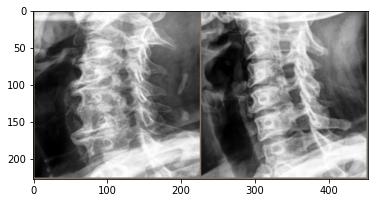

In [58]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # if title is not None:
    #     plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# # 학습 데이터의 배치를 얻습니다.
# inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(images)

imshow(out)

---

In [40]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler


class BaseDataLoader(DataLoader):
    """
    Base class for all data loaders
    """
    def __init__(self, dataset, batch_size, shuffle, validation_split, num_workers, collate_fn=default_collate):
        self.validation_split = validation_split
        self.shuffle = shuffle

        self.batch_idx = 0
        self.n_samples = len(dataset)

        self.sampler, self.valid_sampler = self._split_sampler(self.validation_split)

        self.init_kwargs = {
            'dataset': dataset,
            'batch_size': batch_size,
            'shuffle': self.shuffle,
            'collate_fn': collate_fn,
            'num_workers': num_workers
        }
        super().__init__(sampler=self.sampler, **self.init_kwargs)

    def _split_sampler(self, split):
        if split == 0.0:
            return None, None

        idx_full = np.arange(self.n_samples)

        np.random.seed(0)
        np.random.shuffle(idx_full)

        if isinstance(split, int):
            assert split > 0
            assert split < self.n_samples, "validation set size is configured to be larger than entire dataset."
            len_valid = split
        else:
            len_valid = int(self.n_samples * split)

        valid_idx = idx_full[0:len_valid]
        train_idx = np.delete(idx_full, np.arange(0, len_valid))

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # turn off shuffle option which is mutually exclusive with sampler
        self.shuffle = False
        self.n_samples = len(train_idx)

        return train_sampler, valid_sampler

    def split_validation(self):
        if self.valid_sampler is None:
            return None
        else:
            return DataLoader(sampler=self.valid_sampler, **self.init_kwargs)


In [31]:
from torchvision import datasets, transforms
# from base import BaseDataLoader


class MnistDataLoader(BaseDataLoader):
    """
    MNIST data loading demo using BaseDataLoader
    """
    def __init__(self, data_dir, batch_size, shuffle=True, validation_split=0.0, num_workers=1, training=True):
        trsfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.data_dir = data_dir
        self.dataset = datasets.MNIST(self.data_dir, train=training, download=True, transform=trsfm)
        super().__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)

In [33]:
test = datasets.MNIST('data', train='True', download=True)

In [34]:
test.__getitem__(0)

(<PIL.Image.Image image mode=L size=28x28 at 0x7FED2CA0A310>, 5)